In [118]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix, roc_auc_score, f1_score, average_precision_score, fbeta_score
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, roc_curve, RocCurveDisplay
from sklearn.neighbors import KNeighborsClassifier
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall, roc_curve
import shap
import sklearn
import joblib
#activate high interaction shell so print() is not necessary to show output. https://stackoverflow.com/questions/31764006/ipython-notebook-display-every-line-output-without-print
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#CHOOSE THE MODEL TO FIT
#modelRunning = 'binaryModel'
modelRunning = 'multiClassModel'

#1. Get data
vmsOp2 = pd.read_csv('data/vmsOp2.csv')
vmsOp2 = vmsOp2.loc[vmsOp2['Date']>'2021-01-01'].copy()

if modelRunning == 'multiClassModel':
    print('MULTICLASS!')
    #2. Balance dataset between fishing operations (A, C, N)
    print('Unbalanced dataset structure:')
    #vmsOp2.groupby('Operation').count()

    #sample same number of points as smallest category(C)
    n_bal = len(vmsOp2.loc[vmsOp2['Operation'] == 'C'])
    C_bal = vmsOp2.loc[vmsOp2['Operation']=='C'] #get all points for C
    A_bal = vmsOp2.loc[vmsOp2['Operation']=='A'].sample(n_bal)
    N_bal = vmsOp2.loc[vmsOp2['Operation']=='N'].sample(n_bal)

    print('Balanced dataset structure:')
    vmsOp2_bal = pd.concat([C_bal, A_bal, N_bal])
    #vmsOp2_bal.groupby('Operation').count()

if modelRunning == 'binaryModel':
    print('BINARY!')
    binaryClasses = {'C':1, 'A':0, 'N':0}
    vmsOp2['Operation'] = vmsOp2['Operation'].replace(binaryClasses)
    #vmsOp2.groupby('Operation').count()
    #sample same number of points as smallest category(1)
    n_bal = len(vmsOp2.loc[vmsOp2['Operation'] == 1])
    n_bal
    bal_1 = vmsOp2.loc[vmsOp2['Operation']==1] #get all points for 1
    bal_0 = vmsOp2.loc[vmsOp2['Operation']==0].sample(n_bal)
    print('Balanced dataset structure:')
    vmsOp2_bal = pd.concat([bal_1, bal_0])
    #vmsOp2_bal.groupby('Operation').count()



MULTICLASS!
Unbalanced dataset structure:
Balanced dataset structure:


labels encoded as:


{'A': 0, 'C': 1, 'N': 2}

vmsOp2 balanced total len: 1320
vmsOp2 balanced training len: 990
vmsOp2 balanced test len: 330


1    117
2    114
0     99
Name: count, dtype: int64

RandomForestClassifier(max_features=1, n_estimators=300)

The model accuracy in the training dataset is: 1.0
The model accuracy in the testing dataset is: 0.7212121212121212


<Axes: xlabel='Operation', ylabel='Speed'>

<Axes: xlabel='Operation', ylabel='CourseCorrected'>

<Axes: xlabel='Operation', ylabel='speedDiff-1'>

<Axes: xlabel='Operation', ylabel='speedDiff+1'>

<Axes: xlabel='Operation', ylabel='cogDiff'>

<Axes: xlabel='Operation', ylabel='DayTime2'>

<Axes: xlabel='Operation', ylabel='bufferCount'>

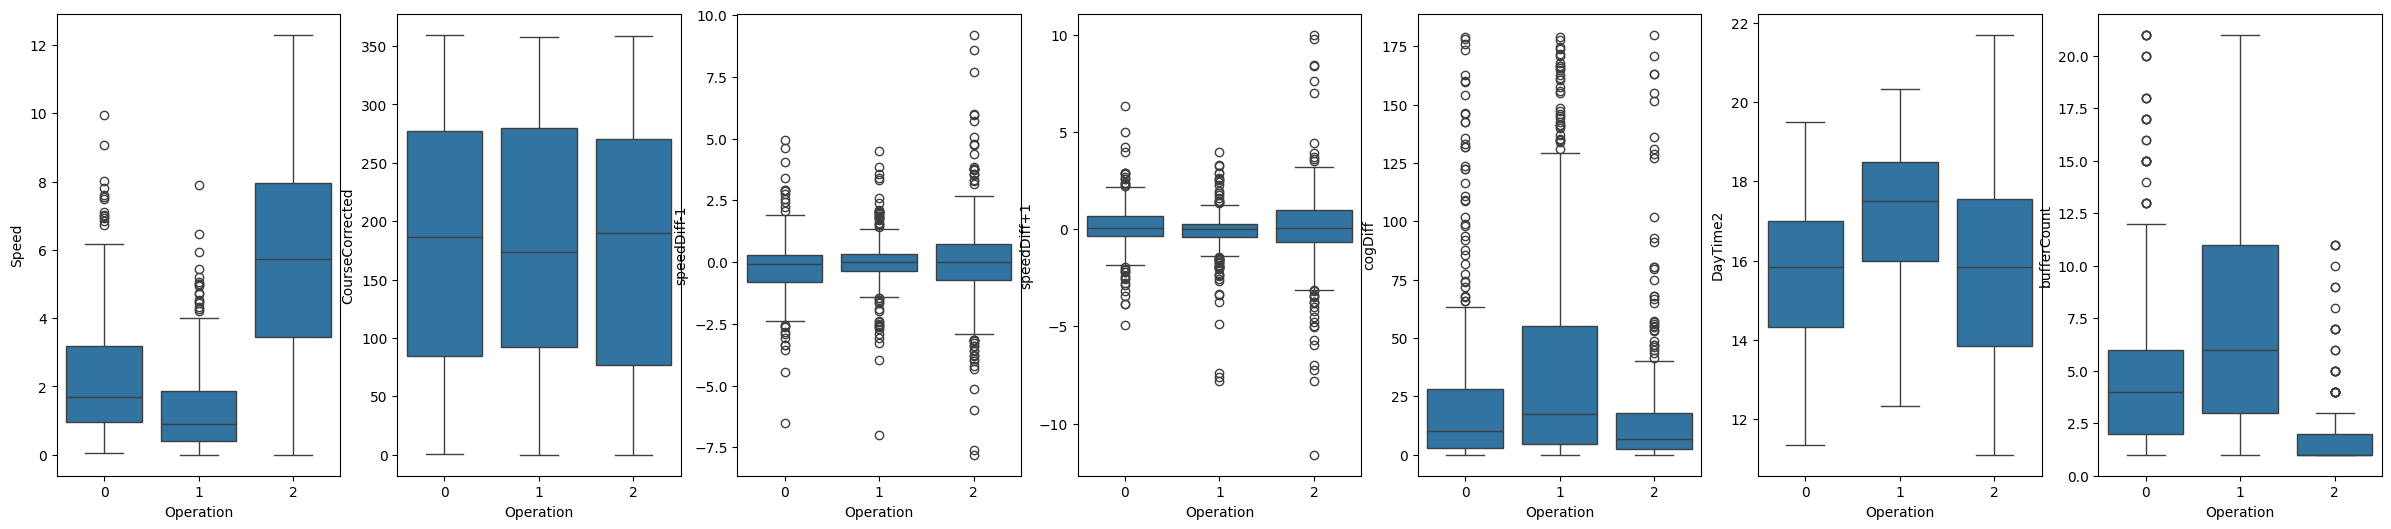

In [152]:
#3. Split dataset into response (y) and predictive variables (x)
finalDF = vmsOp2_bal
finalDF.to_csv('data/' + modelRunning + '/balanced_dataset.csv')
x = finalDF[['Speed', 'CourseCorrected', 'cogDiff', 'speedDiff+1', 'speedDiff-1', 'DayTime2', 'bufferCount']]
y = finalDF.Operation

#encode labels 
le = LabelEncoder()
y = pd.Series(le.fit_transform(y))
print('labels encoded as:')
dict(zip(le.classes_, le.transform(le.classes_)))

#4. Split x, y datasets into training and validation 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
print('vmsOp2 balanced total len: ' + str(len(finalDF)))
print('vmsOp2 balanced training len: ' + str(len(y_train)))
print('vmsOp2 balanced test len: ' + str(len(y_test)))

x_train.to_csv('data/' + modelRunning + '/x_train.csv', index=False)
y_train.to_csv('data/' + modelRunning + '/y_train.csv', index=False)
x_test.to_csv('data/' + modelRunning + '/x_test.csv', index=False)
y_test.to_csv('data/' + modelRunning + '/y_test.csv', index=False)

y_test.value_counts()

#5. Check preliminar model accuracy (without hyperparameter tunning)
model = RandomForestClassifier(n_estimators=300, max_features=1)
model.fit(x_train, y_train) 
print('The model accuracy in the training dataset is: ' + str(model.score(x_train, y_train)))
print('The model accuracy in the testing dataset is: ' + str(model.score(x_test, y_test)))

plotdf = pd.concat([pd.DataFrame(pd.Series(y_train.reset_index(drop=True)), columns=['Operation']), x_train.reset_index(drop=True)], axis=1)

fig, axs = plt.subplots(ncols=7, figsize=(30,6))
#sns.scatterplot( x='Course', y='Speed', hue='Operation', data=plotdf, ax=axs[0])
sns.boxplot(x='Operation', y='Speed', data=plotdf, ax=axs[0])
sns.boxplot(x='Operation', y='CourseCorrected', data=plotdf, ax=axs[1])
sns.boxplot(x='Operation', y='speedDiff-1', data=plotdf, ax=axs[2])
sns.boxplot(x='Operation', y='speedDiff+1', data=plotdf, ax=axs[3])
sns.boxplot(x='Operation', y='cogDiff', data=plotdf, ax=axs[4])
sns.boxplot(x='Operation', y='DayTime2', data=plotdf, ax=axs[5])
sns.boxplot(x='Operation', y='bufferCount', data=plotdf, ax=axs[6])


In [194]:
#call x_train, y_train from folder so can iterate different hyperparams with same data
#6. Hyperparameter tunning
bootstrap = [True]
max_depth = [6]
max_features = ['sqrt']
max_leaf_nodes = [100,1000, 1500]
max_samples = [0.5]
min_impurity_decrease = [0]
min_samples_leaf = [5]
min_samples_split = [2,3,4,5] 
n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num = 3)]

param_grid = {'n_estimators': n_estimators,
            'max_features': max_features,
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf,
            'bootstrap': bootstrap,
            'max_leaf_nodes' : max_leaf_nodes,
            'min_impurity_decrease' : min_impurity_decrease,
            'max_samples' : max_samples
            }

scorers = {
    'precision_score': make_scorer(precision_score, average='micro')
    ,'recall_score': make_scorer(recall_score, average='micro')
    ,'f1_score': make_scorer(f1_score, average='micro')
    ,'accuracy_score': make_scorer(accuracy_score)
}

modelH = RandomForestClassifier(class_weight='balanced')
print('Fitting final model with hyperparameter tunning...')
rf_Grid = GridSearchCV(estimator = modelH, param_grid=param_grid, scoring=scorers, refit='accuracy_score', cv=5, verbose=1, n_jobs=10)
rf_Grid.fit(x_train, y_train)

print('Model best parameters:')
print(rf_Grid.best_params_)
print('\n Model accuracy in the training dataset is: ' + str(rf_Grid.score(x_train, y_train)))
print('Model accuracy in the test dataset: ' + str(rf_Grid.score(x_test, y_test)))

rf_Grid.best_estimator_.score
pd.DataFrame(rf_Grid.cv_results_).to_csv('results/' + modelRunning + '/gridSearchCV_results.csv')
joblib.dump(rf_Grid, 'results/' + modelRunning + '/fittedModel_' + modelRunning + '.pkl')




Fitting final model with hyperparameter tunning...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=10,
             param_grid={'bootstrap': [True], 'max_depth': [6],
                         'max_features': ['sqrt'],
                         'max_leaf_nodes': [100, 1000, 1500],
                         'max_samples': [0.5], 'min_impurity_decrease': [0],
                         'min_samples_leaf': [5],
                         'min_samples_split': [2, 3, 4, 5],
                         'n_estimators': [100, 550, 1000]},
             refit='accuracy_score',
             scoring={'accuracy_score': make_scorer(accuracy_score),
                      'f1_score': make_scorer(f1_score, average=micro),
                      'precision_score': make_scorer(precision_score, average=micro),
                      'recall_score': make_scorer(recall_score, average=micro)},
             verbose=1)

Model best parameters:
{'bootstrap': True, 'max_depth': 6, 'max_features': 'sqrt', 'max_leaf_nodes': 1000, 'max_samples': 0.5, 'min_impurity_decrease': 0, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1000}

 Model accuracy in the training dataset is: 0.7525252525252525
Model accuracy in the test dataset: 0.7363636363636363


<bound method ClassifierMixin.score of RandomForestClassifier(class_weight='balanced', max_depth=6,
                       max_leaf_nodes=1000, max_samples=0.5,
                       min_impurity_decrease=0, min_samples_leaf=5,
                       min_samples_split=5, n_estimators=1000)>

['results/multiClassModel/fittedModel_multiClassModel.pkl']

Accuracy of the final model is: 0.7363636363636363
                   A           C           N
precision   0.610619    0.790909    0.813084
recall      0.696970    0.743590    0.763158
F-score     0.650943    0.766520    0.787330
totals     99.000000  117.000000  114.000000


<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

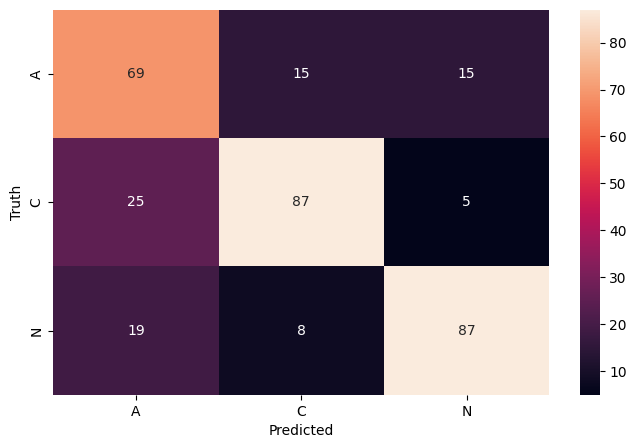

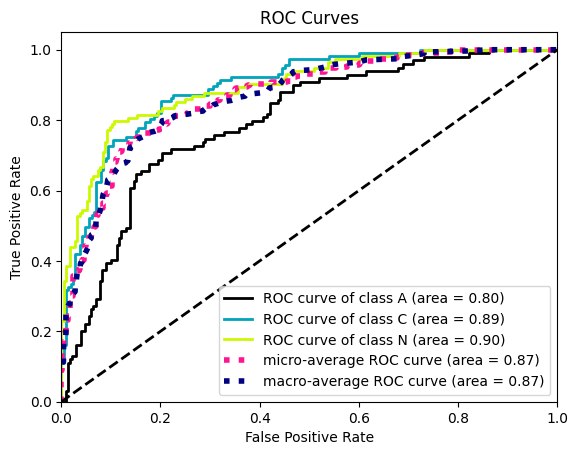

<Axes: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

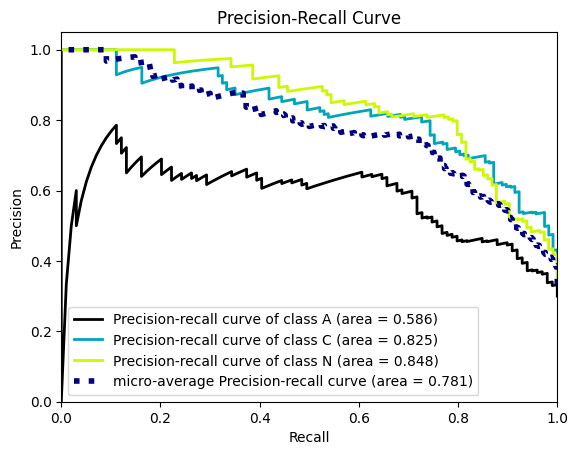

In [196]:
#from modelCheckFunctions import model_scoring_and_confusion_matrix_binaryModel
from modelCheckFunctions import *

#7. Check fitted model performance
#Get model predictions 
y_pred = rf_Grid.best_estimator_.predict(x_test)
y_score = rf_Grid.best_estimator_.predict_proba(x_test)

#Confusion matrix
if modelRunning == 'binaryModel': 
    model_scoring_and_confusion_matrix_binaryModel(y_test, y_pred)
if modelRunning == 'multiClassModel': 
    model_scoring_and_confusion_matrix_multiclassModel(y_test, y_pred)

#Roc curve
plot_roc(le.inverse_transform(y_test), y_score)
plt.show()

#Precision recall curve
plot_precision_recall(le.inverse_transform(y_test), y_score)
plt.show()